In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Iterate through files in directory
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input\Submission.csv
input\fer2013\fer2013\fer2013.bib
input\fer2013\fer2013\fer2013.csv
input\fer2013\fer2013\README


In [2]:
# Import additional libraries
import math
import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
# Read the dataset
df = pd.read_csv('input/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# Display unique emotion labels
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [5]:
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


In [6]:
# Count occurrences of each emotion label
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

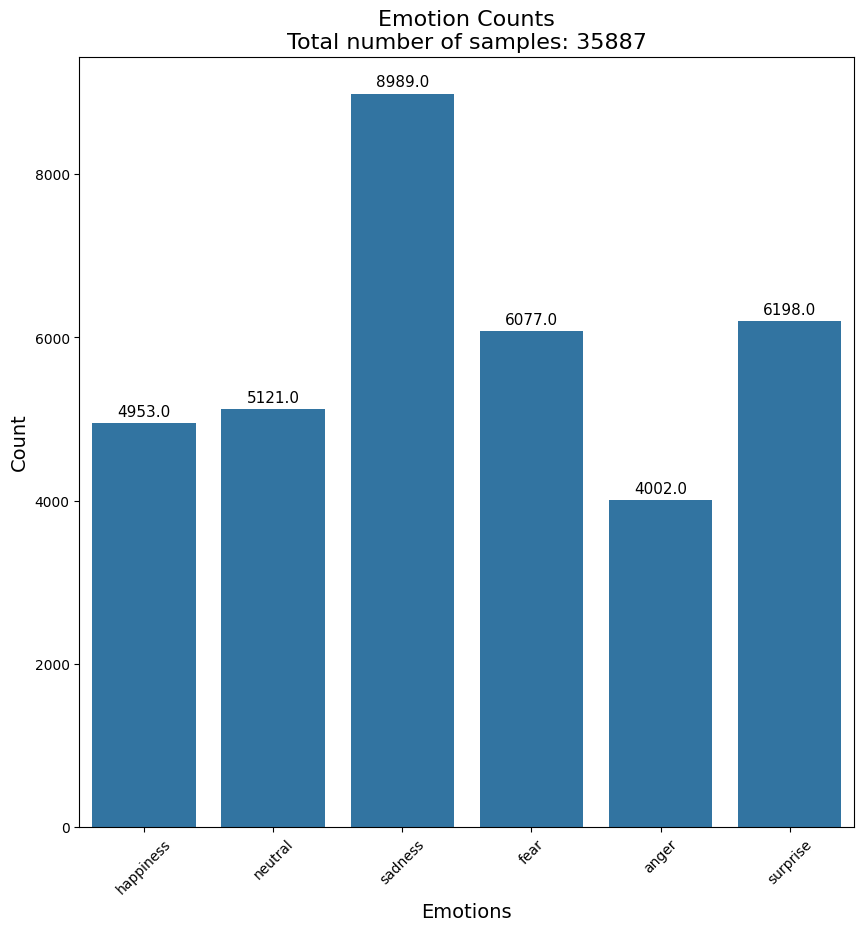

Total number of samples: 35887


In [7]:
# Assuming 'disgust' is labeled as 1
emotion_counts = df.emotion.value_counts()
emotion_counts = emotion_counts.drop(labels=[1], errors='ignore')  # Drop 'disgust' if it exists

# Plot bar chart for emotion counts
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set plot labels and title
plt.title('Emotion Counts\nTotal number of samples: {}'.format(len(df)), fontsize=16)
plt.xlabel('Emotions', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=range(len(emotion_counts.index)),
           labels=[emotion_label_to_text[label] for label in emotion_counts.index], rotation=45)
plt.show()

# Print the total number of data points
total_samples = len(df)
print("Total number of samples:", total_samples)


In [8]:
# Calculate the square root of the number of pixels in each image
math.sqrt(len(df.pixels[0].split(' ')))

48.0

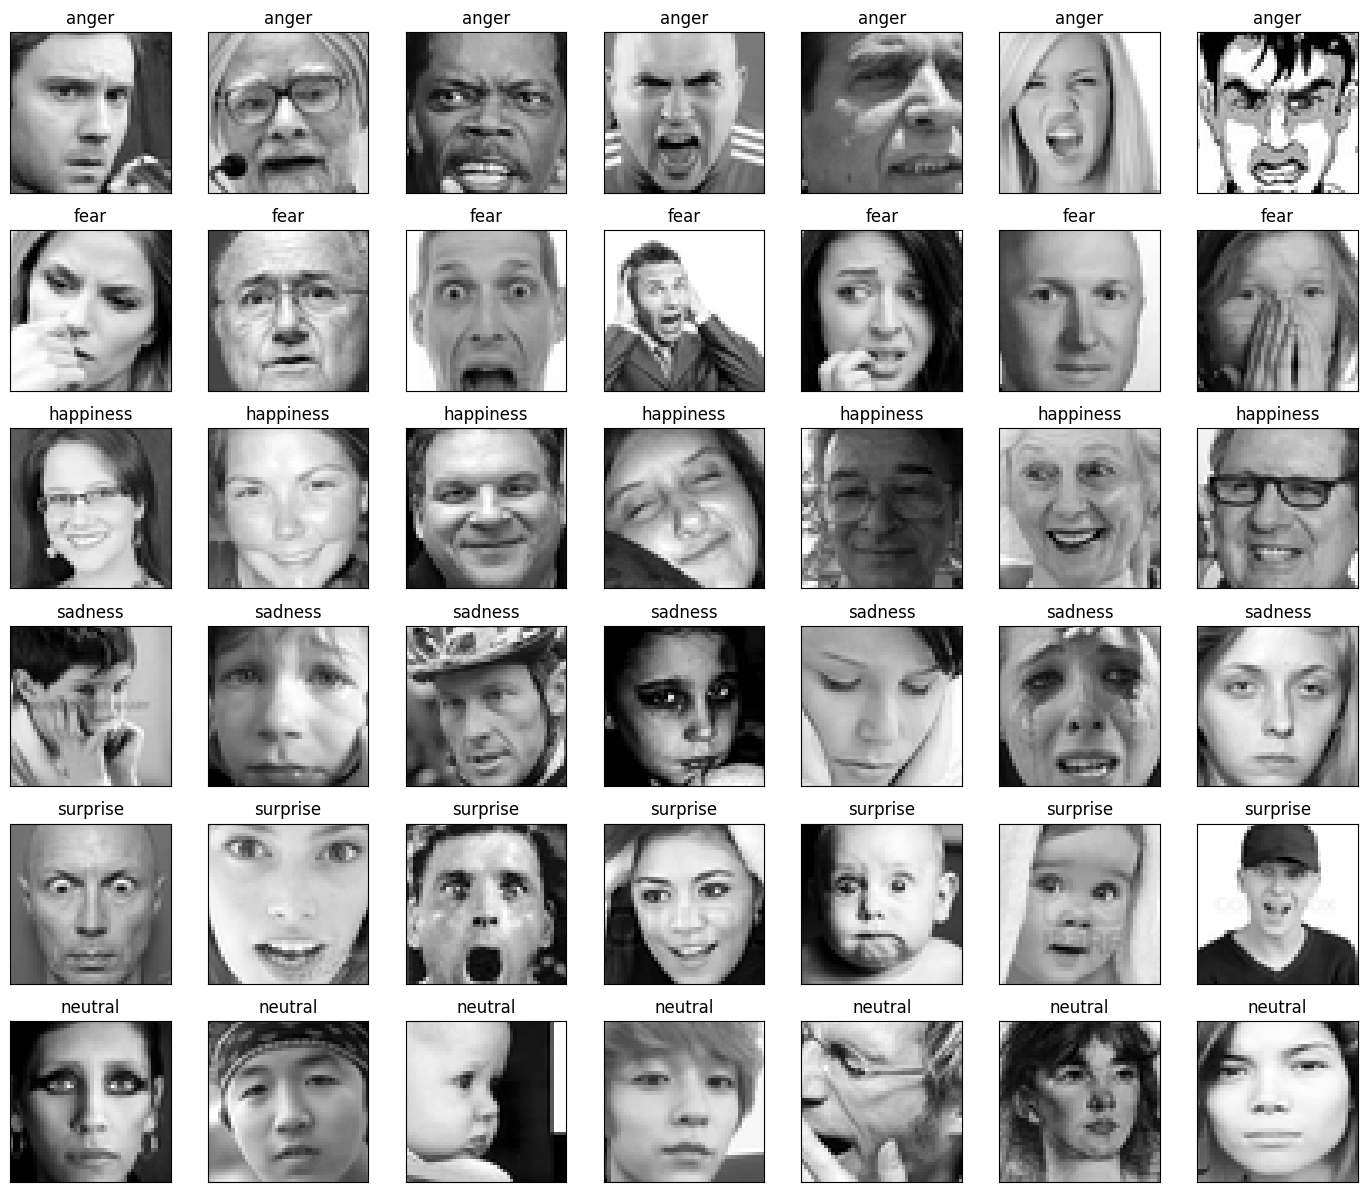

In [9]:
# Filter out the "disgust" rows if emotion 'disgust' is labeled as 1
filtered_df = df[df.emotion != 1]

# Display images corresponding to each emotion label
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(filtered_df.emotion.unique()):
    emotion_samples = filtered_df[filtered_df.emotion == label].head(7)  # Take first 7 samples for each emotion
    for j in range(7):
        px = emotion_samples.pixels.iloc[j]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

plt.show()


In [10]:
# Convert pixel data into array format
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [11]:
# Display the shape of the image array
img_array.shape

(35887, 48, 48)

In [12]:
# Convert grayscale images to RGB format
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


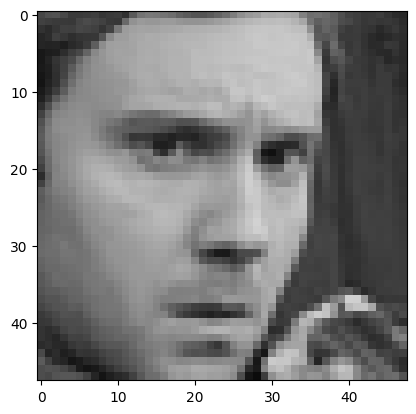

In [13]:
# Display an image from the dataset
pyplot.imshow(img_features[0].astype(np.uint8));

In [14]:
# Encode emotion labels using LabelEncoder
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [15]:
# Map emotion labels to their encoded values
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [16]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(img_features,
                                                    img_labels,
                                                    shuffle = True,
                                                    stratify = img_labels,
                                                    test_size = 0.3,
                                                    random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp,
                                                    y_temp,
                                                    shuffle = True,
                                                    stratify = y_temp,
                                                    test_size = 1/3,
                                                    random_state = 42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((25120, 48, 48, 3),
 (7178, 48, 48, 3),
 (3589, 48, 48, 3),
 (25120, 7),
 (7178, 7),
 (3589, 7))

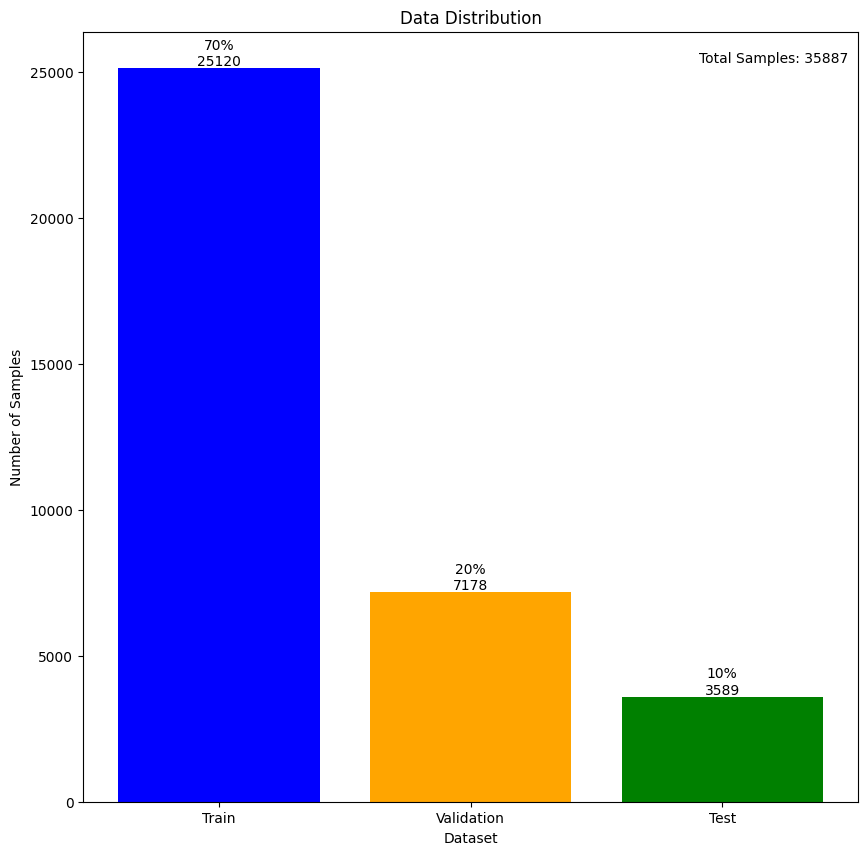

In [17]:
# Calculate the number of samples in each set
train_size = len(X_train)
valid_size = len(X_valid)
test_size = len(X_test)

# Calculate the total number of samples and the ratios
total_samples = len(df)
train_ratio = train_size / total_samples
valid_ratio = valid_size / total_samples
test_ratio = test_size / total_samples

# Plot the data distribution bar chart
plt.figure(figsize=(10, 10))
bars = plt.bar(['Train', 'Validation', 'Test'], [train_size, valid_size, test_size], color=['blue', 'orange', 'green'])
plt.title('Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Add text annotations for the ratios
plt.text(0, train_size + 100, f'{train_ratio:.0%}\n{train_size}', ha='center')
plt.text(1, valid_size + 100, f'{valid_ratio:.0%}\n{valid_size}', ha='center')
plt.text(2, test_size + 100, f'{test_ratio:.0%}\n{test_size}', ha='center')

# Add total number of samples annotation in the top right
plt.text(2.5, max(train_size, valid_size, test_size) + 200, f'Total Samples: {total_samples}', ha='right')

plt.show()


In [18]:
del df
del img_features
del img_labels

In [19]:
# Define image dimensions and number of classes
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [20]:
# Normalize pixel values to range [0, 1]
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [21]:
# Load pre-trained VGG16 model
vgg = tf.keras.applications.VGG16(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

In [22]:
# Allow layers in VGG model to be trainable
for layer in vgg.layers:
    layer.trainable = True

In [23]:
# Display summary of VGG model
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Define a function to build the classification model
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [25]:
# Build the classification model on top of VGG
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping, lr_scheduler]

In [27]:
import tensorflow as tf

# Define the ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True)

# Create the data generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Repeat the dataset using RepeatDataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, *X_train.shape[1:]], [None, *y_train.shape[1:]])
)
train_dataset = train_dataset.repeat()  # Repeat the dataset indefinitely



In [28]:
import keras
# Set batch size and number of epochs for training
batch_size = 32
epochs = 50
optims = [keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),]

# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

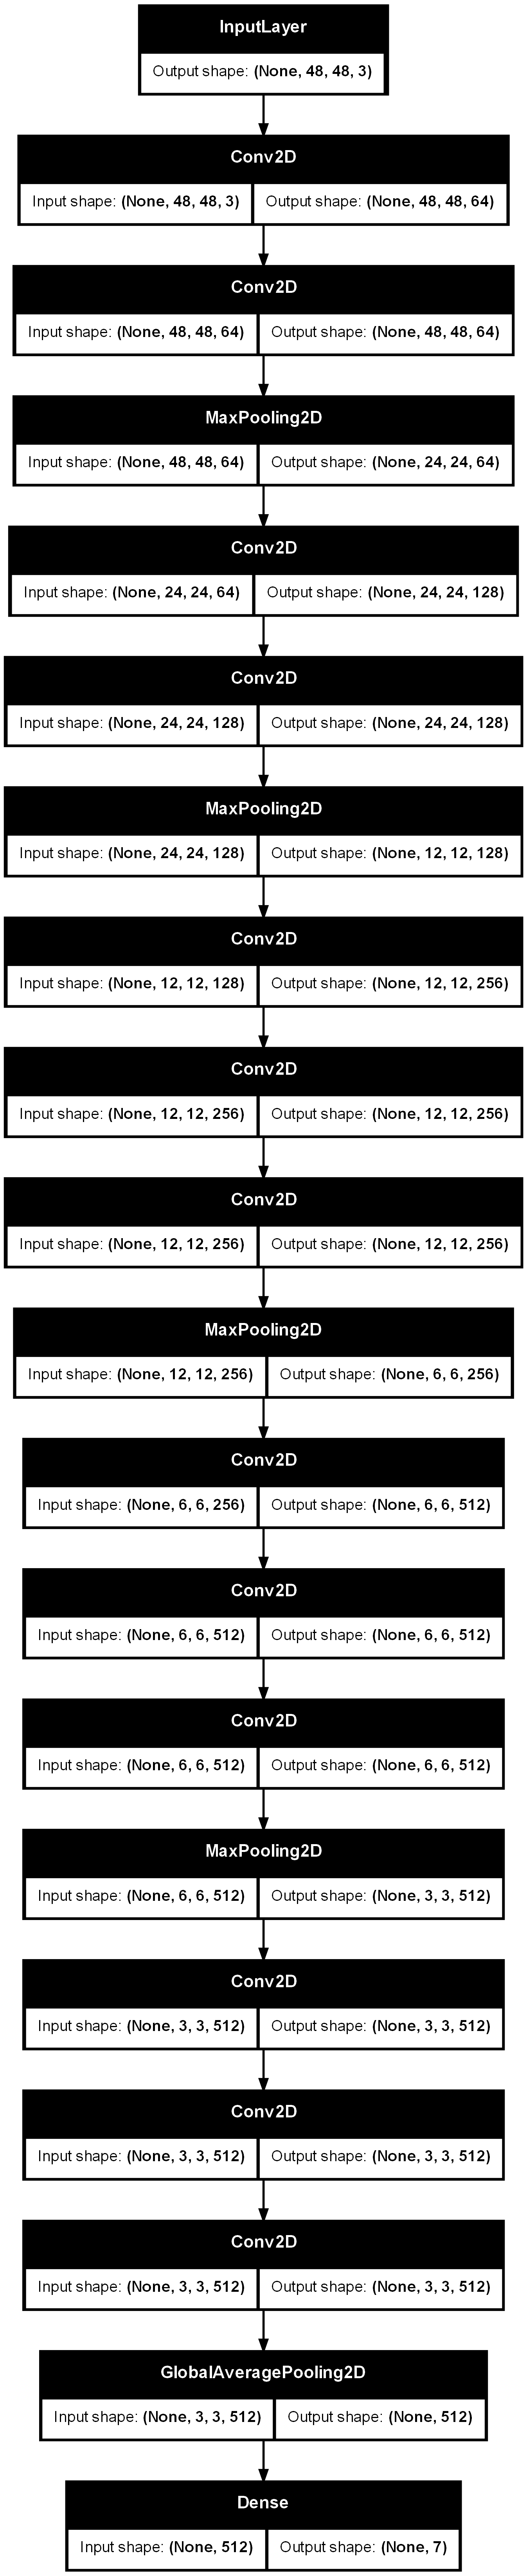

In [29]:
# Visualize the architecture of the model
dot_img_file = 'model_SGD.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [30]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_valid, y_valid),
                    steps_per_epoch=int(len(X_train) / batch_size),
                    epochs=epochs,
                    callbacks=callbacks)

# Save the trained model
model_yaml = model.to_json()
with open("model_SGD.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model_SGD.h5")


Epoch 1/50


c:\Users\demir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ━━━━━━━━━━━━━━━━━━━━ 1840s 2s/step - accuracy: 0.3567 - loss: 1.6198 - val_accuracy: 0.5201 - val_loss: 1.2679 - learning_rate: 0.0010
Epoch 2/50


c:\Users\demir\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


785/785 ━━━━━━━━━━━━━━━━━━━━ 145s 184ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5201 - val_loss: 1.2679 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1195s 2s/step - accuracy: 0.5188 - loss: 1.2657 - val_accuracy: 0.5656 - val_loss: 1.1353 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5656 - val_loss: 1.1353 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1040s 1s/step - accuracy: 0.5532 - loss: 1.1795 - val_accuracy: 0.5814 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5814 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy: 0.5752 - loss: 1.1143 - val_accuracy: 0.5988 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 8/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accur

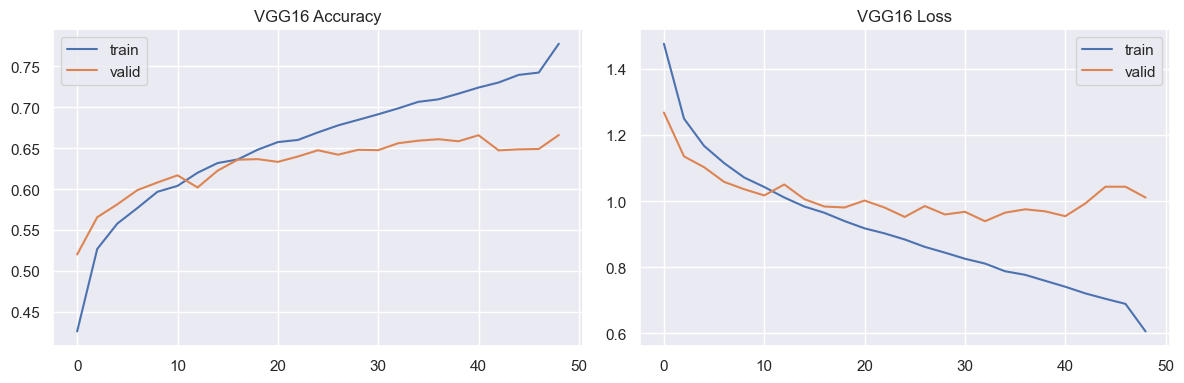

In [31]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Extract accuracy and loss values
epochs = history.epoch
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Filter out epochs with 0 accuracy or loss values
filtered_epochs = []
filtered_train_accuracy = []
filtered_val_accuracy = []
filtered_train_loss = []
filtered_val_loss = []

for epoch, acc, val_acc, loss, val_loss in zip(epochs, train_accuracy, val_accuracy, train_loss, val_loss):
    if acc != 0 and val_acc != 0 and loss != 0 and val_loss != 0:
        filtered_epochs.append(epoch)
        filtered_train_accuracy.append(acc)
        filtered_val_accuracy.append(val_acc)
        filtered_train_loss.append(loss)
        filtered_val_loss.append(val_loss)

# Plot training and validation accuracy and loss
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=filtered_epochs, y=filtered_train_accuracy, label='train')
sns.lineplot(x=filtered_epochs, y=filtered_val_accuracy, label='valid')
plt.title('VGG16 Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=filtered_epochs, y=filtered_train_loss, label='train')
sns.lineplot(x=filtered_epochs, y=filtered_val_loss, label='valid')
plt.title('VGG16 Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 294ms/step


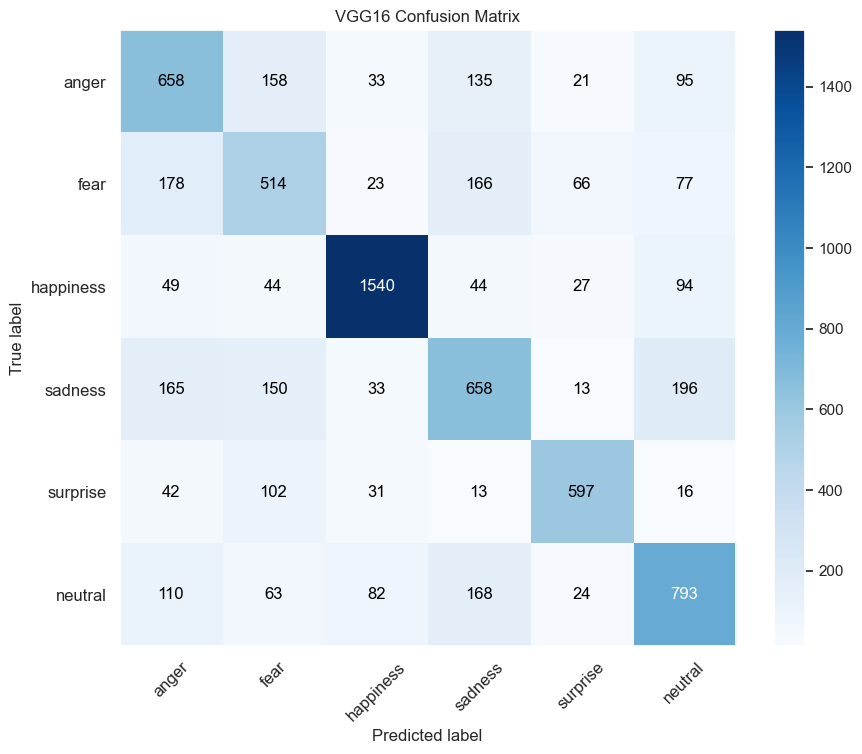

In [34]:
from sklearn.metrics import classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# Define emotion label mapping
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Predict and plot the confusion matrix
yhat_valid = np.argmax(model.predict(X_valid), axis=1)

# Adjust predictions for removed "disgust" class and remove "disgust" from true labels
yhat_valid_no_disgust = np.where(yhat_valid > 1, yhat_valid - 1, yhat_valid)
y_valid_no_disgust = np.delete(y_valid, 1, axis=1)

# Plot confusion matrix
confusion_matrix = skplt.metrics.plot_confusion_matrix(np.argmax(y_valid_no_disgust, axis=1), yhat_valid_no_disgust, figsize=(10, 8))

# Set labels for ticks, excluding "disgust"
tick_marks = np.arange(len(mapper) - 1)  # Exclude "disgust"
plt.xticks(tick_marks, [mapper[i] for i in range(len(mapper)) if i != 1], rotation=45)
plt.yticks(tick_marks, [mapper[i] for i in range(len(mapper)) if i != 1])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('VGG16 Confusion Matrix')

plt.savefig("confusion_matrix_dcnn.png")
plt.show()



225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 254ms/step


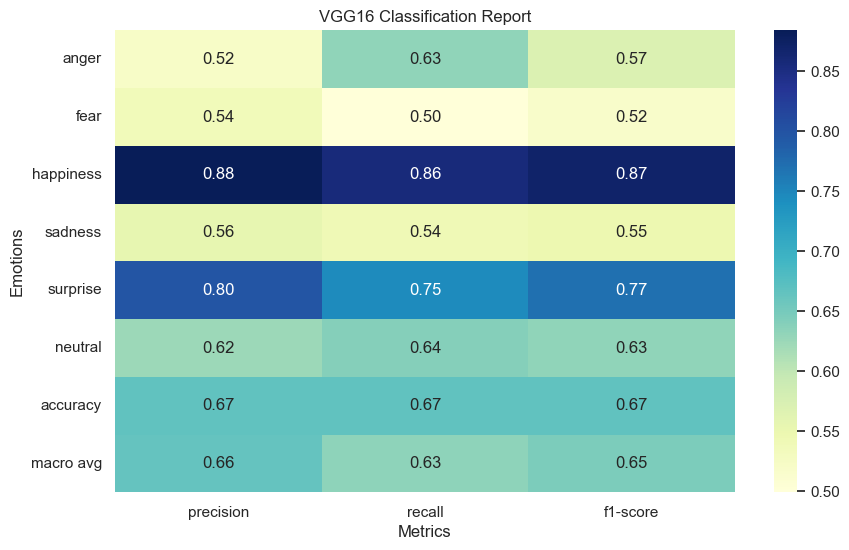

In [35]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=emotion_label_to_text.values(), output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Drop the "disgust" row
df_report.drop("disgust", inplace=True)

# Plot the modified report
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('VGG16 Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Emotions')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


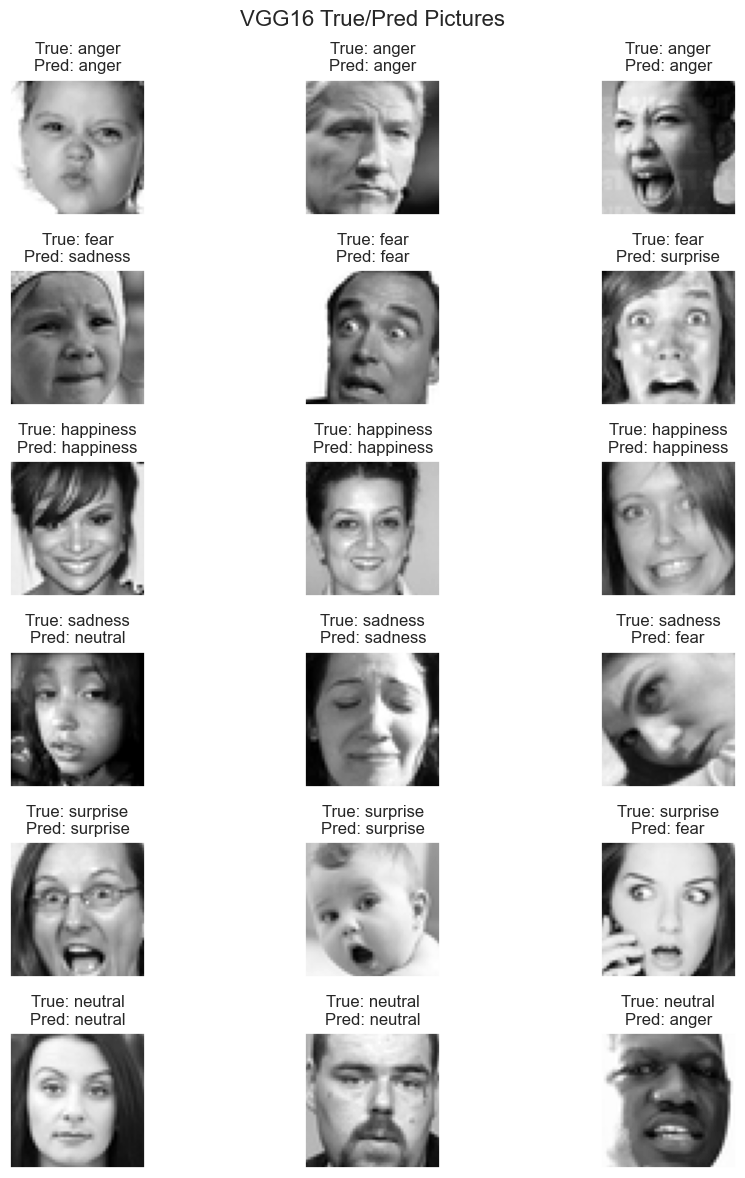

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define emotion label mapping
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Display random samples of true and predicted emotions
np.random.seed(2)

# Define the emotions excluding "disgust"
emotions_exclude_disgust = [0, 2, 3, 4, 5, 6]

fig = plt.figure(1, (10, 12))

# Add title above the table
fig.suptitle('VGG16 True/Pred Pictures', fontsize=16)

# Iterate over each emotion category except "disgust"
for i, emotion_idx in enumerate(emotions_exclude_disgust):
    # Select 3 random image indices corresponding to the current emotion
    random_img_indices = np.random.choice(np.where(y_valid[:, emotion_idx] == 1)[0], size=3, replace=False)
    
    # Loop over the selected images for the current emotion
    for j, random_img_idx in enumerate(random_img_indices):
        # Display the image
        ax = plt.subplot(6, 3, i * 3 + j + 1)
        sample_img = X_valid[random_img_idx, :, :, 0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Predict the emotion label using the model
        sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        prediction = model.predict(sample_img_rgb.reshape(1, 48, 48, 3))
        
        # Display true and predicted emotion labels
        true_emotion = mapper[emotion_idx]
        pred_emotion = mapper[np.argmax(prediction[0])]
        ax.set_title(f"True: {true_emotion}\nPred: {pred_emotion}")

plt.tight_layout()
plt.show()


